In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


**要約**

1. **必要なライブラリのインポート**：データ処理、プロット、テキストクリーニング、機械学習のために必要なライブラリをインポートしている。
2. **データの読み込み**：訓練データセットとテストデータセットを読み込んでいる。
3. **データ前処理**：
   - 欠損値を確認し、補完している。
   - テキストクリーニング関数を定義し、適用して、句読点、HTMLタグ、リンクなどを除去している。
   - ストップワードを除去している。
4. **特徴抽出**：`TfidfVectorizer`を使用してテキスト特徴を抽出している。
5. **データ分割**：データを訓練セットと検証セットに分割している。
6. **モデル訓練**：ロジスティック回帰モデルを訓練している。
7. **モデル評価**：モデルの精度を評価し、分類レポートと混同行列を出力している。

#  ライブラリのインポート

In [2]:
# 'accelerate'ライブラリを最新バージョンにアップグレードしてインストール
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


In [3]:
# pandasライブラリをインポート（データ操作用）
import pandas as pd
# numpyライブラリをインポート（数値計算用）
import numpy as np
# osライブラリをインポート（OSの機能を使用するため）
import os
# matplotlibライブラリをインポート（データ可視化用）
import matplotlib
# matplotlib.pyplotモジュールをインポート（データ可視化用の簡易インターフェース）
import matplotlib.pyplot as plt
# matplotlib.patchesモジュールをインポート（グラフ上のパッチや形状を作成するため）
import matplotlib.patches as mpatches
# seabornライブラリをインポート（統計データの可視化用）
import seaborn as sns

# torchライブラリをインポート（PyTorch、深層学習用）
import torch
# transformersライブラリからBertTokenizerとBertForSequenceClassificationをインポート（BERTモデル用）
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# PyTorchのDataLoaderとDatasetをインポート（データ読み込み用）
from torch.utils.data import DataLoader, Dataset
# transformersライブラリからBertTokenizerとBertModelを再度インポート（BERTモデル用）
from transformers import BertTokenizer, BertModel
# PyTorchのnnモジュールをインポート（ニューラルネットワーク構築用）
import torch.nn as nn
# PyTorchのoptimモジュールをインポート（最適化アルゴリズム用）
import torch.optim as optim
# sklearnのmetricsモジュールからいくつかの評価指標をインポート（モデル評価用）
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

2024-07-26 07:29:57.116157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 07:29:57.116286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 07:29:57.250548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# データのダウンロード

In [4]:
# トレーニングデータをCSVファイルから読み込み、pandasデータフレームとして保存
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
# テストデータをCSVファイルから読み込み、pandasデータフレームとして保存
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [5]:
# トレーニングデータの最初の10行を表示
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
# トレーニングデータの概要情報を表示
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


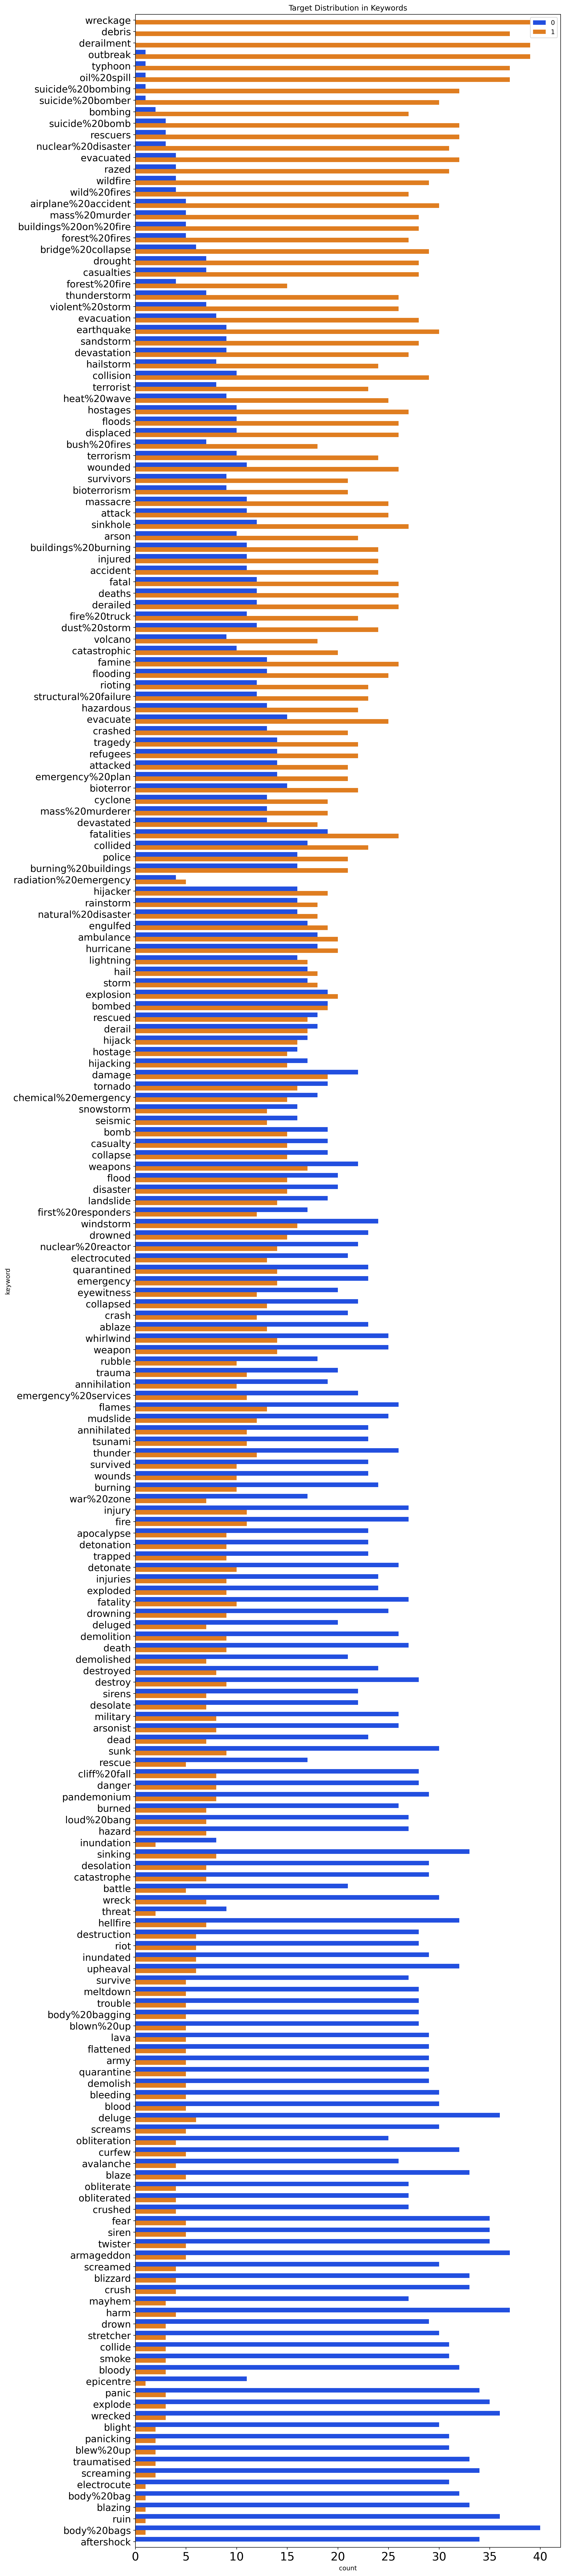

In [7]:
#import matplotlib.pyplot as plt
#import seaborn as sns

# 各キーワードの平均ターゲット値を計算
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

# キーワードのターゲット分布をプロット
fig = plt.figure(figsize=(12, 72), dpi=256)

# target_meanでキーワードを並べ替え
sorted_train_data = train_data.sort_values(by='target_mean', ascending=False)

sns.countplot(y=sorted_train_data['keyword'], 
              hue=sorted_train_data['target'], 
              palette="bright")

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=15)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

# 一時列を削除
train_data.drop(columns=['target_mean'], inplace=True)


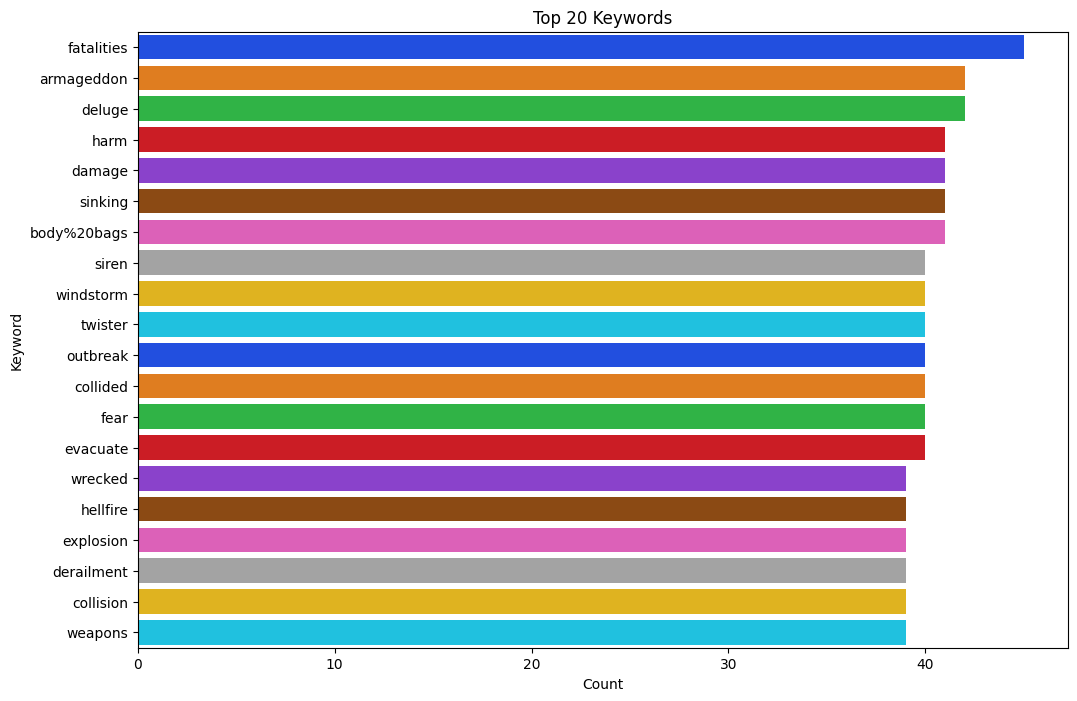

In [8]:
# 上位20のキーワードの出現回数をプロット
plt.figure(figsize=(12, 8))
sns.countplot(y=train_data['keyword'], order=train_data['keyword'].value_counts().iloc[:20].index, palette='bright')
plt.title('Top 20 Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

In [9]:
# text_hammerライブラリをインストール
!pip install text_hammer

# text_hammerライブラリをインポート
import text_hammer as th

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.2 requires shapely>=2, but you have s

In [10]:
# テキスト前処理関数を定義
def text_preprocessing(df, col_name):
    column = col_name
    # テキストを小文字に変換
    df[column] = df[column].progress_apply(lambda x: str(x).lower())
    # メールアドレスを削除
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    # HTMLタグを削除
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    # 特殊文字を削除
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    # アクセント付き文字を削除
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    return df


In [11]:
# tqdmライブラリをインストール（プログレスバーの表示用）
!pip install tqdm

# tqdmライブラリからtqdm_notebookをインポート
from tqdm._tqdm_notebook import tqdm_notebook

# pandasデータフレームに対してtqdmのプログレスバーを有効化
tqdm_notebook.pandas()

# transformersライブラリからAutoTokenizerとTFBertModelをインポート
from transformers import AutoTokenizer, TFBertModel


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
# トレーニングデータの'text'列に対して前処理を実行し、結果をtrain_cleaned_dataに保存
train_cleaned_data = text_preprocessing(train_data, 'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [13]:
# ターゲットが0のデータを抽出して表示
train_cleaned_data[train_cleaned_data.target == 0]

,id,keyword,location,text,target
15,23,NaN,NaN,whats up man,0
16,24,NaN,NaN,i love fruits,0
17,25,NaN,NaN,summer is lovely,0
18,26,NaN,NaN,my car is so fast,0
19,28,NaN,NaN,what a goooooooaaaaaal,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,engineshed great atmosphere at the british lio...,0
7582,10834,wrecked,NaN,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,NaN,NaN,these boxes are ready to explode exploding kit...,0
7587,10841,NaN,NaN,sirens everywhere,0


In [14]:
# 前処理済みのデータをコピーしてtrain_dataに保存
train_data = train_cleaned_data.copy()

In [15]:
# トレーニングデータの最初の10行を表示
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1
5,8,NaN,NaN,rockyfire update california hwy 20 closed in b...,1
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1
7,13,NaN,NaN,im on top of the hill and i can see a fire in ...,1
8,14,NaN,NaN,theres an emergency evacuation happening now i...,1
9,15,NaN,NaN,im afraid that the tornado is coming to our area,1


In [16]:
# テストデータの'text'列を表示
test_data['text']

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [17]:
# テストデータの概要情報を表示
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


# ワードクラウド

In [18]:
# wordcloudライブラリからSTOPWORDSをインポート（ワードクラウド作成用のストップワード）
from wordcloud import STOPWORDS
# nltk.corpusからstopwordsをインポート（自然言語処理用のストップワード）
from nltk.corpus import stopwords
# wordcloudライブラリからWordCloudをインポート（ワードクラウド作成用）
from wordcloud import WordCloud

In [19]:
# 英語のストップワードをセットとして取得
stop_words = set(stopwords.words('english'))
# ストップワードを除去して'text'列を更新
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

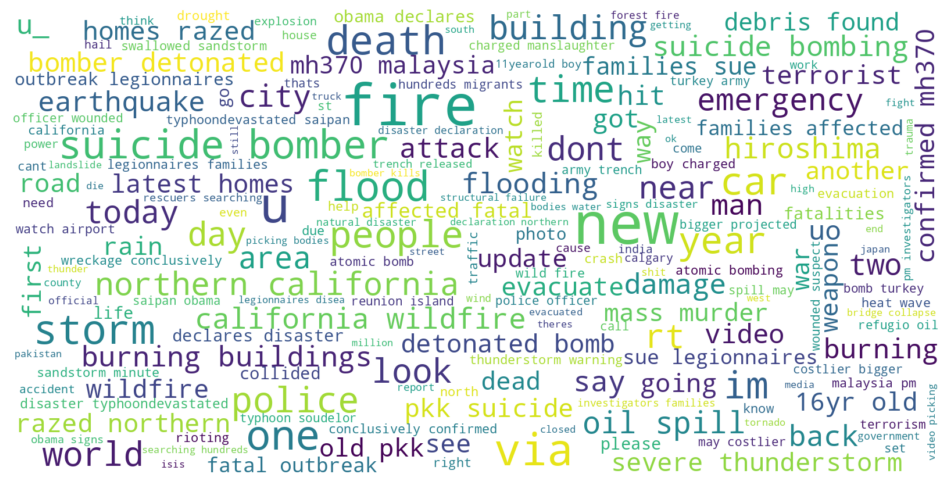

In [20]:
# 災害関連のツイートのワードクラウドを作成
disaster_tweets = train_data[train_data.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

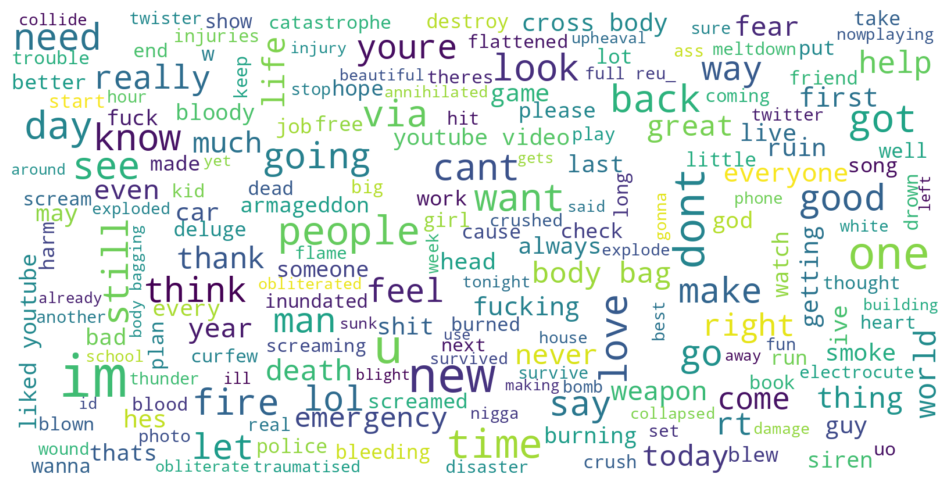

In [21]:
# ポジティブツイートのワードクラウドを作成
formal_tweets = train_data[train_data.target == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# EDA

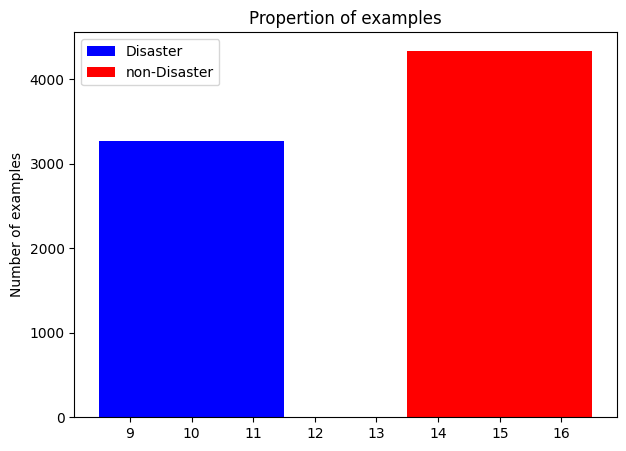

In [22]:
# 各クラスのサンプル数を抽出
Real_len = train_data[train_data['target'] == 1].shape[0]
Not_len = train_data[train_data['target'] == 0].shape[0]

# 2つのクラスの棒グラフを作成
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Disaster", color='blue')
plt.bar(15,Not_len,3, label="non-Disaster", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

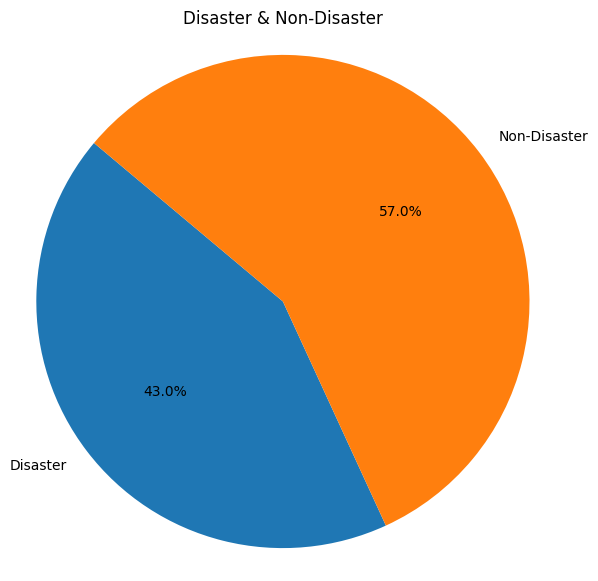

In [23]:
# 円グラフ
labels = ['Disaster', 'Non-Disaster']
sizes = [Real_len, Not_len]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')  # 円グラフを円形にする
plt.title('Disaster & Non-Disaster')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


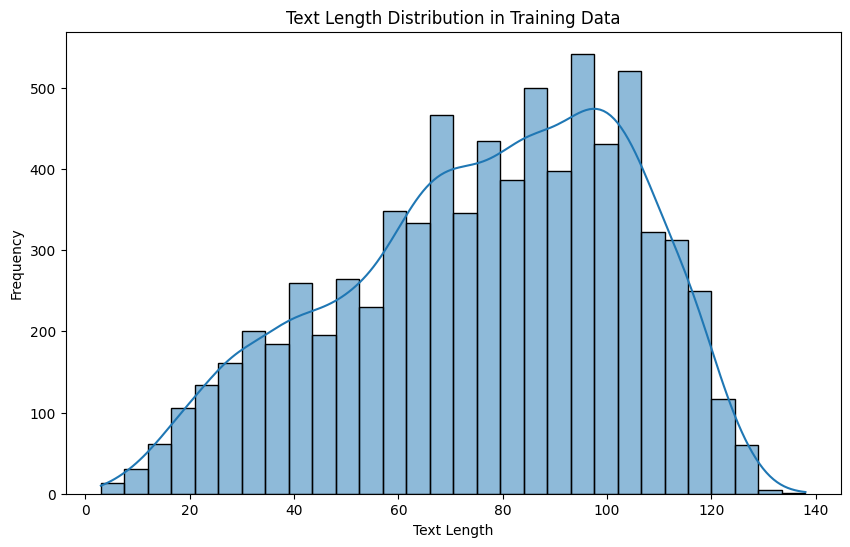

In [24]:
# テキストの長さの分布を可視化
train_data['text_length'] = train_data['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution in Training Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 前処理

* 1.Tweetsの前処理
* 2.URL削除
* 3.HTMLタグを削除
* 4.絵文字を削除
* 5.特殊文字を置換
* 6.非ASCII文字を削除
* 7.省略形を展開
* 8.特定の修正
* 9.クリーニング
* 10.句読点を削除

In [25]:
# re（正規表現操作用）ライブラリをインポート
import re
# string（文字列操作用）ライブラリをインポート
import string


In [26]:
# トレーニングデータをCSVファイルから読み込み、pandasデータフレームとして保存
# 'id'列をint16型、'target'列をint8型として読み込む
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
# テストデータをCSVファイルから読み込み、pandasデータフレームとして保存
# 'id'列をint16型として読み込む
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv', dtype={'id': np.int16})
# 不要な列を削除
train_df = train_df.drop(['location', 'keyword'], axis=1)
test_df = test_df.drop(['location', 'keyword'], axis=1)

In [27]:
# URLを削除する関数を定義
def remove_url(tweet):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',tweet)

# HTMLタグを削除する関数を定義
def remove_html(tweet):
    html=re.compile(r'<.*?>')
    return html.sub(r'',tweet)

# 絵文字を削除する関数を定義
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

In [28]:
# 特殊文字を置換する関数を定義
def special_characters(tweet):
    
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)  
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)
    tweet = re.sub(r"didn`t", "did not", tweet)
    tweet = re.sub(r"i\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"i\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"i\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let us", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"that\x89Ûªs", "that is", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"here\x89Ûªs", "here is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"you\x89Ûªre", "you are", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"You\x89Ûªve", "You have", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"You\x89Ûªll", "You will", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)  
    tweet = re.sub(r"Ì©", "", tweet)
       
    # 文字実体参照を置換
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    return tweet

# 非ASCII文字を削除する関数を定義
def remove_nonASCII(tweet):
    tweet = ''.join([x for x in tweet if x in string.printable])
    return tweet

In [29]:
# 短縮形を展開する関数を定義
def expand_contractions(tweet):
    
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"i'M", "I am", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"you'd", "you would", tweet)
    tweet = re.sub(r"You'd", "You would", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"You've", "You have", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"You'll", "You will", tweet)  
    tweet = re.sub(r"y'know", "you know", tweet)  
    tweet = re.sub(r"Y'know", "You know", tweet)  
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"We've", "We have", tweet) 
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"We'd", "We would", tweet)
    tweet = re.sub(r"WE'VE", "We have", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"We'll", "We will", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"They'd", "They would", tweet)  
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"They've", "They have", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"They'll", "They will", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"He'll", "He will", tweet)
    tweet = re.sub(r"she's", "she is", tweet)
    tweet = re.sub(r"She's", "She is", tweet)
    tweet = re.sub(r"she'll", "she will", tweet)
    tweet = re.sub(r"She'll", "She will", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"It'll", "It will", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"Isn't", "Is not", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"Who's", "Who is", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"here's", "here is", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Where's", "Where is", tweet)  
    tweet = re.sub(r"wHeRE's", "where is", tweet)  
    tweet = re.sub(r"how's", "how is", tweet)  
    tweet = re.sub(r"How's", "How is", tweet)  
    tweet = re.sub(r"how're", "how are", tweet)  
    tweet = re.sub(r"How're", "How are", tweet) 
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"DON'T", "Do not", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"DIDN'T", "Did not", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    
    return tweet

In [30]:
# 特定の修正を行う関数を定義
def specific_corrections(tweet):
    
    # 略語の置換
    tweet = re.sub(r"b/c", "because", tweet)
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/out", "without", tweet)
    tweet = re.sub(r"w/o", "without", tweet)
    tweet = re.sub(r"w/", "with ", tweet)   
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"c/o", "care of", tweet)
    tweet = re.sub(r"p/u", "pick up", tweet)
    tweet = re.sub(r"\n", " ", tweet)
   
    # タイポの修正
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"wrld", "world", tweet)   
    tweet = re.sub(r"shld", "should", tweet)    
    tweet = re.sub(r"thruuu", "through", tweet)
    tweet = re.sub(r"probaly", "probably", tweet)
    tweet = re.sub(r"whatevs", "whatever", tweet)
    tweet = re.sub(r"colomr", "colour", tweet)
    tweet = re.sub(r"pileq", "pile", tweet)
    tweet = re.sub(r"firefightr", "firefighter", tweet)
    tweet = re.sub(r"LAIGHIGN", "laughing", tweet)
    tweet = re.sub(r"EXCLUSIV", "Exclusive", tweet) 
    tweet = re.sub(r"belo-ooow", "below", tweet)  
    tweet = re.sub(r"who-ooo-ole", "whole", tweet)  
    tweet = re.sub(r"brother-n-law", "father-in-law", tweet)  
    tweet = re.sub(r"referencereference", "reference", tweet)
    
    return tweet

In [31]:
# その他のテキストクリーニングを行う関数を定義
def clean_others(tweet):
    
    # 略語の展開
    tweet = re.sub(r"Dr\.", "Doctor", tweet)
    tweet = re.sub(r"f\. M\.O\.P\.", "featuring Mash Out Posse", tweet)
    tweet = re.sub(r"M\.O\.P\.", "Mash Out Posse", tweet)
    tweet = re.sub(r"M\.O\.P", "Mash Out Posse", tweet)
    tweet = re.sub(r"P\.O\.P\.E\.", "Pope", tweet)
    tweet = re.sub(r"S\.O\.S\.", "SOS", tweet)
    tweet = re.sub(r"s\.o\.s\.", "SOS", tweet)  
    tweet = re.sub(r"Fire Co\.", "Fire Company", tweet)
    tweet = re.sub(r"Holt and Co\.", "Holt and Company", tweet)
    tweet = re.sub(r"roofing co\.", "roofing company", tweet)
    tweet = re.sub(r"Costa Co\.", "Costa County", tweet)
    tweet = re.sub(r"York Co\.", "York County", tweet)
    tweet = re.sub(r"Fairfax Co\.", "Fairfax County", tweet)
    tweet = re.sub(r"I\.S\.I\.S\.", "ISIS", tweet)
    tweet = re.sub(r"U\.N\.", "United Nations", tweet)
    tweet = re.sub(r"U\.S\.", "United States", tweet)
    tweet = re.sub(r"U\.S", "United States", tweet)
    tweet = re.sub(r"U\.s\.", "United States", tweet)
    tweet = re.sub(r"U\.s", "United States", tweet)
    tweet = re.sub(r"U-S\.", "United States", tweet)
    tweet = re.sub(r"U\.S National", "United States National", tweet)
    tweet = re.sub(r"LANCASTER N\.H\.", "Lancaster New Hampshire", tweet)
    tweet = re.sub(r"Manchester N\.H\.", "Manchester New Hampshire", tweet)
    
    return tweet

In [32]:
# 不要な単語を削除する関数を定義
def remove_non_alnum(tweet):
    punctuation = re.compile('[^A-Za-z0-9]+')
    return punctuation.sub(r' ',tweet)

# 句読点を削除する関数を定義
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# 先頭、末尾、および余分なスペースを削除する関数を定義
def remove_extra_spaces(text):
    text = re.sub('\s+', ' ', text).strip() 
    return text

In [33]:
# 前処理済みのツイートを格納するリストを定義
preprocessed_tweets_train = [] 

# トレーニングデータの各ツイートに対して前処理を実行
for tweet in tqdm_notebook(train_df['text'].values):
    tweet = remove_url(tweet)
    tweet = remove_html(tweet)
    tweet = remove_emoji(tweet)
    tweet = special_characters(tweet)
    tweet = remove_nonASCII(tweet)
    tweet = expand_contractions(tweet)
    tweet = specific_corrections(tweet)
    tweet = remove_html(tweet)
    tweet = clean_others(tweet)
    tweet = remove_punct(tweet)
    tweet = remove_non_alnum(tweet)
    tweet = remove_extra_spaces(tweet)
    preprocessed_tweets_train.append(tweet.strip())
    
# 前処理済みのツイートをデータフレームに反映    
train_df['text'] = preprocessed_tweets_train

  0%|          | 0/7613 [00:00<?, ?it/s]

In [34]:
# 前処理済みのツイートを格納するリストを定義
preprocessed_tweets_test = []  

# テストデータの各ツイートに対して前処理を実行
for tweet in tqdm_notebook(test_df['text'].values):
    tweet = remove_url(tweet)
    tweet = remove_html(tweet)
    tweet = remove_emoji(tweet)
    tweet = special_characters(tweet)
    tweet = remove_nonASCII(tweet)
    tweet = expand_contractions(tweet)
    tweet = specific_corrections(tweet)
    tweet = remove_html(tweet)
    tweet = clean_others(tweet)
    tweet = remove_punct(tweet)
    tweet = remove_non_alnum(tweet)
    tweet = remove_extra_spaces(tweet)
    preprocessed_tweets_test.append(tweet.strip())

# 前処理済みのツイートをデータフレームに反映    
test_df['text'] = preprocessed_tweets_test

  0%|          | 0/3263 [00:00<?, ?it/s]

# 可視化

In [35]:
# matplotlib.pyplotモジュールをインポート（データ可視化用）
import matplotlib.pyplot as plt
# seabornライブラリをインポート（統計データの可視化用）
import seaborn as sns
# numpyライブラリをインポート（数値計算用）
import numpy as np

# seabornライブラリをインストール
!pip install seaborn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


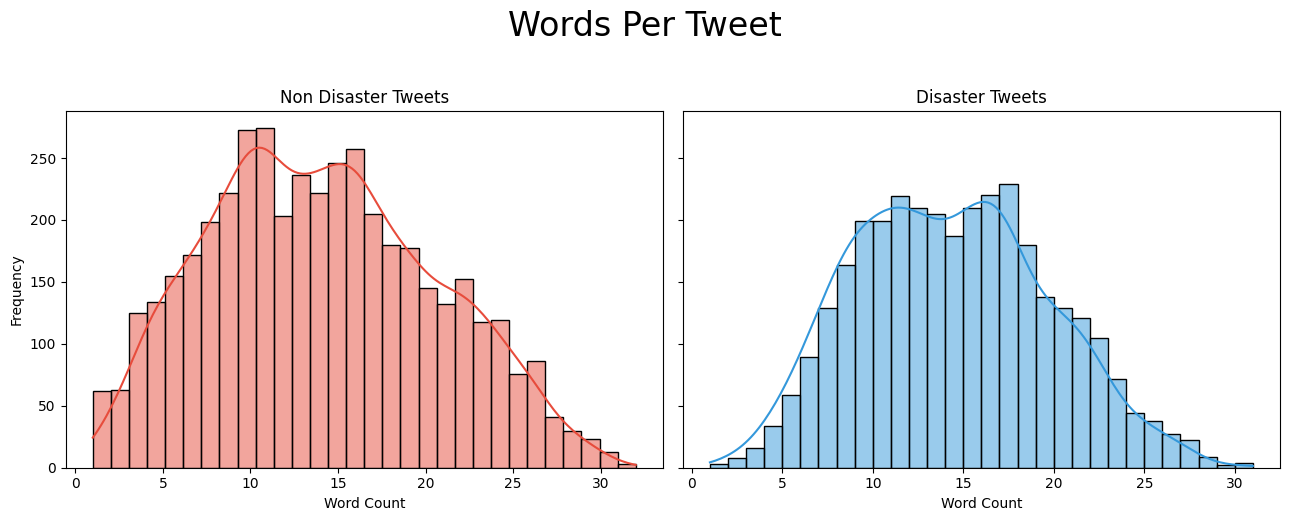

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 単語数のヒストグラムと密度曲線を描く関数を定義
def plot_word_number_histogram(textno, textyes):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13, 5), sharey=True)
    sns.histplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c', kde=True, bins=30)
    sns.histplot(textyes.str.split().map(lambda x: len(x)), ax=axes[1], color='#3498db', kde=True, bins=30)
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    fig.tight_layout()
    plt.show()

# 各ツイートの単語数を計算
textno = train_df[train_df['target'] == 0]['text']
textyes = train_df[train_df['target'] == 1]['text']
plot_word_number_histogram(textno, textyes)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


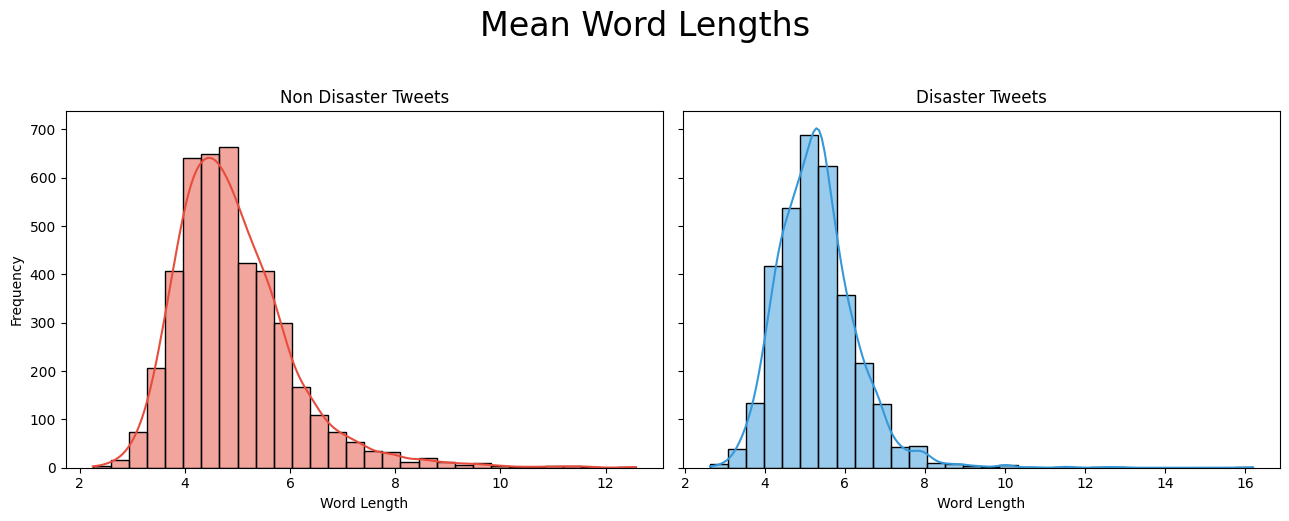

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 平均単語長のヒストグラムと密度曲線を描く関数を定義
def plot_word_len_histogram(textno, textyes):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13, 5), sharey=True)
    
    # 各ツイートの平均単語長を計算
    textno_word_len = textno.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
    textyes_word_len = textyes.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
    
    # ヒストグラムと密度曲線を描く
    sns.histplot(textno_word_len, ax=axes[0], color='#e74c3c', kde=True, bins=30)
    sns.histplot(textyes_word_len, ax=axes[1], color='#3498db', kde=True, bins=30)
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()
    plt.show()

# 前処理済みデータを使用してプロットを作成
plot_word_len_histogram(train_df[train_df['target'] == 0]['text'], train_df[train_df['target'] == 1]['text'])


# モデルの訓練と予測

In [38]:
# torchsummaryライブラリをインストール
!pip install torchsummary

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [39]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time
import gc

# WandBを無効化
os.environ["WANDB_DISABLED"] = "true"

# BERTのトークナイザーをロード
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# データのトークナイズ
def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# 仮にtrain_dfが訓練データセットだとする
train_texts = train_df['text'].tolist()  # テキストデータをリストに変換
train_labels = train_df['target'].tolist()  # ラベルデータをリストに変換
train_encodings = tokenize_data(train_texts)  # テキストデータをトークナイズ

# カスタムデータセットの作成
class DisasterDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  # インデックスに基づいてトークナイズされたデータを取得
        item['labels'] = torch.tensor(self.labels[idx])  # ラベルをテンソルに変換して追加
        return item

    def __len__(self):
        return len(self.labels)  # データセットの長さを返す

train_dataset = DisasterDataset(train_encodings, train_labels)  # カスタムデータセットをインスタンス化
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # DataLoaderを作成し、バッチサイズとシャッフルを設定

# カスタムニューラルネットワークモデルを定義
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')  # BERTモデルをロード
        self.dropout = nn.Dropout(dropout)  # ドロップアウト層を定義
        self.linear = nn.Linear(self.bert.config.hidden_size, 2)  # 全結合層を定義

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)  # BERTの出力を取得
        pooled_output = outputs[1]  # プーリングされた出力を取得
        dropout_output = self.dropout(pooled_output)  # ドロップアウトを適用
        linear_output = self.linear(dropout_output)  # 全結合層を適用
        return linear_output  # 出力を返す

# デバイスの自動選択
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} for training")  # 使用するデバイスを表示

model = BertClassifier()  # モデルをインスタンス化
model.to(device)  # モデルをデバイスに移動
criterion = nn.CrossEntropyLoss()  # 損失関数を定義
optimizer = AdamW(model.parameters(), lr=2e-5)  # オプティマイザーを定義

# カスタムトレーナークラスを定義
class CustomTrainer:
    def __init__(self, model, train_dataset, batch_size, lr, epochs, device, n_splits=2):
        self.model = model
        self.train_dataset = train_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.device = device
        self.criterion = nn.CrossEntropyLoss()  # 損失関数を定義
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)  # オプティマイザーを定義
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)  # DataLoaderを作成
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(self.train_loader) * self.epochs)  # スケジューラーを定義
        self.n_splits = n_splits
        self.kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)

    def train(self):
        oof_preds = np.zeros((len(self.train_dataset), 2))
        fold_hist = {}

        for fold, (train_idx, val_idx) in enumerate(self.kfold.split(np.arange(len(self.train_dataset)))):
            print(f'Fold {fold + 1}')
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

            train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=train_subsampler)
            val_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=val_subsampler)

            self.model.to(self.device)
            self.model.train()

            for epoch in range(self.epochs):
                start_time = time.time()
                total_loss = 0
                correct_predictions = 0

                for batch in train_loader:
                    self.optimizer.zero_grad()
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    outputs = self.model(input_ids, attention_mask)
                    loss = self.criterion(outputs, labels)
                    total_loss += loss.item()

                    _, preds = torch.max(outputs, dim=1)
                    correct_predictions += torch.sum(preds == labels)

                    loss.backward()
                    self.optimizer.step()
                    self.scheduler.step()

                avg_loss = total_loss / len(train_loader)
                train_accuracy = correct_predictions.double() / len(train_idx)
                epoch_time = time.time() - start_time
                print(f'Epoch {epoch + 1}/{self.epochs} - {epoch_time:.1f}s - loss: {avg_loss:.4f} - accuracy: {train_accuracy:.4f}')

                self.model.eval()
                val_loss = 0
                val_correct = 0

                val_preds = np.zeros((len(val_idx), 2))
                val_labels = np.zeros(len(val_idx))

                with torch.no_grad():
                    for i, batch in enumerate(val_loader):
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        labels = batch['labels'].to(self.device)

                        outputs = self.model(input_ids, attention_mask)
                        loss = self.criterion(outputs, labels)
                        val_loss += loss.item()

                        _, preds = torch.max(outputs, dim=1)
                        val_correct += torch.sum(preds == labels)

                        val_preds[i*self.batch_size:(i+1)*self.batch_size] = outputs.cpu().numpy()
                        val_labels[i*self.batch_size:(i+1)*self.batch_size] = labels.cpu().numpy()

                avg_val_loss = val_loss / len(val_loader)
                val_accuracy = val_correct.double() / len(val_idx)
                print(f'Fold {fold + 1} - val_loss: {avg_val_loss:.4f} - val_accuracy: {val_accuracy:.4f}')

                fold_hist[fold] = {'val_loss': avg_val_loss, 'val_accuracy': val_accuracy}

                oof_preds[val_idx] = val_preds

                self.model.train()

        return oof_preds, fold_hist

    def predict(self, test_dataset):
        self.model.to(self.device)
        self.model.eval()
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        all_predictions = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(probs, dim=1)

                all_predictions.extend(preds.cpu().numpy())

        return np.array(all_predictions)

# モデルの初期化と訓練
trainer = CustomTrainer(
    model=model,
    train_dataset=train_dataset,
    batch_size=24,
    lr=2e-5,
    epochs=4,
    device=device,
    n_splits=2  # 交差検証の分割数
)

# モデルを訓練
oof_preds, fold_hist = trainer.train()

# フォールドごとの結果を出力
for fold, metrics in fold_hist.items():
    print(f'Fold {fold + 1}: Val Loss: {metrics["val_loss"]:.4f}, Val Accuracy: {metrics["val_accuracy"]:.4f}')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using cuda for training


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 1
Epoch 1/4 - 33.6s - loss: 0.4932 - accuracy: 0.7725
Fold 1 - val_loss: 0.3936 - val_accuracy: 0.8300
Epoch 2/4 - 35.0s - loss: 0.3591 - accuracy: 0.8579
Fold 1 - val_loss: 0.3991 - val_accuracy: 0.8369
Epoch 3/4 - 37.4s - loss: 0.2629 - accuracy: 0.9033
Fold 1 - val_loss: 0.4493 - val_accuracy: 0.8222
Epoch 4/4 - 36.4s - loss: 0.1771 - accuracy: 0.9359
Fold 1 - val_loss: 0.5018 - val_accuracy: 0.8224
Fold 2
Epoch 1/4 - 36.8s - loss: 0.4147 - accuracy: 0.8329
Fold 2 - val_loss: 0.1796 - val_accuracy: 0.9593
Epoch 2/4 - 36.6s - loss: 0.3186 - accuracy: 0.8768
Fold 2 - val_loss: 0.1456 - val_accuracy: 0.9553
Epoch 3/4 - 36.6s - loss: 0.2709 - accuracy: 0.9010
Fold 2 - val_loss: 0.1337 - val_accuracy: 0.9574
Epoch 4/4 - 36.6s - loss: 0.2372 - accuracy: 0.9180
Fold 2 - val_loss: 0.1316 - val_accuracy: 0.9587
Fold 1: Val Loss: 0.5018, Val Accuracy: 0.8224
Fold 2: Val Loss: 0.1316, Val Accuracy: 0.9587


# 提出

In [40]:
# テストデータの予測
test_texts = test_data['text'].tolist()
test_encodings = tokenize_data(test_texts)
test_dataset = DisasterDataset(test_encodings, [0] * len(test_texts))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()  # モデルを評価モードに切り替え
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(probs, dim=1)
        
        all_predictions.extend(preds.cpu().numpy())

# NumPy配列に変換
all_predictions = np.array(all_predictions)

# NumPy配列に変換
submission = pd.DataFrame({'id': test_data['id'], 'target': all_predictions})
submission.to_csv("/kaggle/working/submission.csv", index=False)

print("Predictions saved to /kaggle/working/submission.csv")

# サンプル提出ファイルを読み込み、出力をフォーマット
sample_sub = pd.read_csv('/kaggle/working/submission.csv')
sub = pd.DataFrame({'id': sample_sub['id'].values.tolist(), 'target': all_predictions})
sub.to_csv('/kaggle/working/submission.csv', index=False)

print("Submission saved to /kaggle/working/submission.csv")


Predictions saved to /kaggle/working/submission.csv
Submission saved to /kaggle/working/submission.csv


In [41]:
# テストデータの予測
test_texts = test_data['text'].tolist()
test_encodings = tokenize_data(test_texts)
test_dataset = DisasterDataset(test_encodings, [0] * len(test_texts))

# カスタムのpredictメソッドを使用して予測を行う
predicted_labels = trainer.predict(test_dataset)

# 結果をCSVファイルに保存
submission = pd.DataFrame({'id': test_data['id'], 'target': predicted_labels})
submission.to_csv("/kaggle/working/submission.csv", index=False)

print("Predictions saved to /kaggle/working/submission.csv")

Predictions saved to /kaggle/working/submission.csv
